### Practical Text Classification With Python and Keras

#### Choosing a Data Set

In [2]:
import pandas as pd
# GLOBAL VARIABLES
data = pd.read_csv("Emotion_final.csv") 
data.info()
data.head()
data[0:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
Text       21459 non-null object
Emotion    21459 non-null object
dtypes: object(2)
memory usage: 335.4+ KB


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
import numpy as np

corpus = np.array(data["Text"])
targets = data["Emotion"]

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(targets)

#### Defining a Baseline Model

In [5]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(corpus, y, test_size=0.25, random_state=1000)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<16094x16471 sparse matrix of type '<class 'numpy.int64'>'
	with 251088 stored elements in Compressed Sparse Row format>

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
X_train.shape

(16094, 16471)

In [9]:
print(type(X_train))
print(type(y_train))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


#### A Primer on (Deep) Neural Networks

In [10]:
X_train = X_train.sorted_indices()
X_test = X_test.sorted_indices()

In [11]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [12]:
input_dim

16471

In [13]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                164720    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 164,786
Trainable params: 164,786
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test),batch_size=10)

In [15]:
from keras.backend import clear_session
clear_session()

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9971
Testing Accuracy:  0.8559


In [17]:
history

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

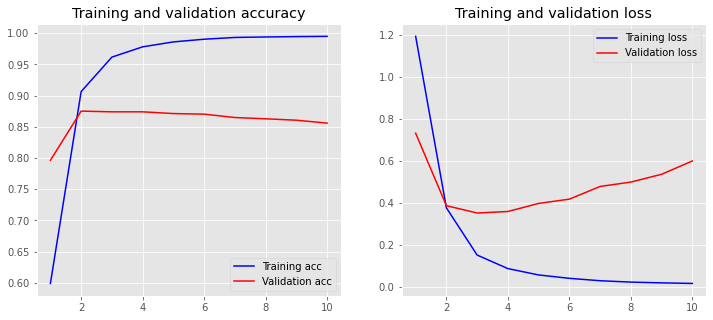

In [19]:
plot_history(history)

#### What Is a Word Embedding?

##### Word Embeddings

In [20]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(sentences_train[2])
print(X_train[2])

i feel his hand on me to stay faithful
[1, 2, 75, 427, 29, 20, 5, 570, 630]


In [21]:
for word in ['am','the', 'all','movie','really','sucked','bad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

am: 24
the: 4
all: 36
movie: 874
really: 42
sucked: 4047
bad: 202


In [22]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[   1    2  469   26 1742   95    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


##### Keras Embedding Layer

In [23]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           825900    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 875,976
Trainable params: 875,976
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9981
Testing Accuracy:  0.8076


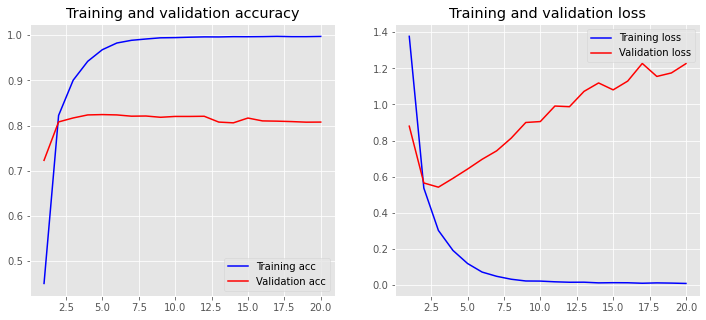

In [24]:
history = model.fit(X_train, y_train,                
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [30]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           825900    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
Total params: 826,476
Trainable params: 826,476
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9783
Testing Accuracy:  0.8936


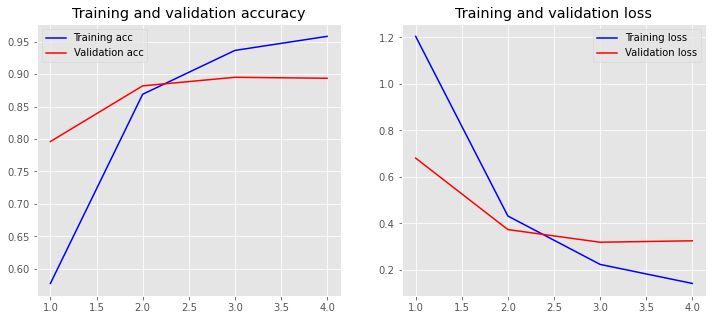

In [31]:
history = model.fit(X_train, y_train,
                    epochs=4,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### Using Pretrained Word Embeddings

In [149]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [150]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'data/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [151]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9263833393873351

In [152]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           825900    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 66        
Total params: 826,476
Trainable params: 576
Non-trainable params: 825,900
_________________________________________________________________


In [1]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [155]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           825900    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 66        
Total params: 826,476
Trainable params: 826,476
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9980
Testing Accuracy:  0.8490


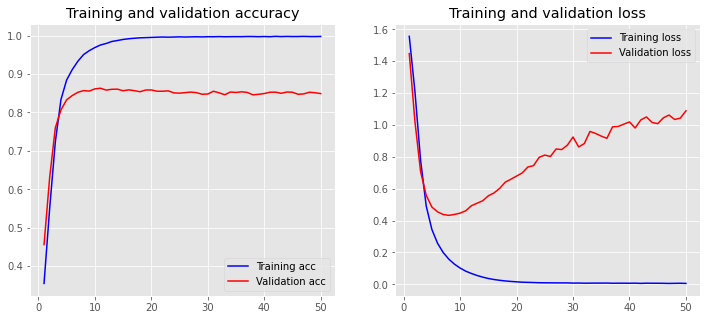

In [156]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [32]:
y_pred  = model.predict(X_test)  

In [33]:
targets = []
for i in range(len(y_pred)):
    targets.append(np.argmax(y_pred[i]+1))
#targets

In [35]:
from sklearn.metrics import f1_score

def report_classification(model,X_test, y_test,targets):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    f1_res = f1_score(y_test, targets, average='macro')
    print("f1_score:  {:.4f}".format(f1_res))
 
report_classification(model,X_test, y_test, targets)

Testing Accuracy:  0.8936
f1_score:  0.8623


In [51]:
np.max(y_test)

5

In [56]:
targets_by_label1 = []
y_test_by_label1 = []
for i in range(len(y_test)):
    if y_test[i] == 1:
        targets_by_label1.append(targets[i])
        y_test_by_label1.append(y_test[i])

In [57]:
def report_classification_new(model,X_test, y_test,targets):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    f1_res = f1_score(y_test_by_label1, targets_by_label1, average='micro')
    print("f1_score:  {:.4f}".format(f1_res))
 
report_classification_new(model,X_test, y_test, targets)

Testing Accuracy:  0.8936
f1_score:  0.8371


##### Convolutional Neural Networks (CNN)

In [158]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1651800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 66        
Total params: 1,717,284
Trainable params: 1,717,284
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9967
Testing Accuracy:  0.9057


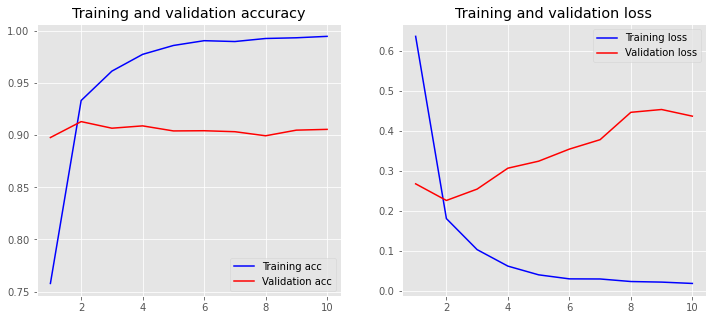

In [159]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##### Hyperparameters Optimization

In [56]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [57]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [58]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits
finished amazon; write to file and proceed? [y/n]y
Running amazon data set
Best Accuracy : 0.8195
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8413


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits
finished imdb; write to file and proceed? [y/n]y
Running imdb data set
Best Accuracy : 0.8185
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8224


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits
finished yelp; write to file and proceed? [y/n]y
Running yelp data set
Best Accuracy : 0.8181
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8341




##### Conclusion

Nous avons pu voir comment faire du NLP avec Keras notamment avec des reseaux de neurones convolutifs.

Nous avons aussi pu utilisé grid search pour l'optimisation des hyperparamètres pour optimiser les performances de notre modèle.